# "Realtime R_0 for USA by county"
> "Dashboard with county level estimates for USA - derived from https://github.com/k-sys/covid-19"

- toc: true
- branch: master
- badges: true
- comments: true
- use_math: true
- author: Ashutosh Sanzgiri
- categories: [covid]

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
import ipywidgets as widgets

FILTERED_REGIONS = [
    'Virgin Islands',
    'American Samoa',
    'Northern Mariana Islands',
    'Guam',
    'Puerto Rico']

FILTERED_REGION_CODES = ['AS', 'GU', 'PR', 'VI', 'MP']

%config InlineBackend.figure_format = 'retina'

In [2]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=[f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])


# Real-World Application to US Data (by counties)

### Setup

Load US state case data from CovidTracking.com

In [3]:
url_counties = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url_counties)

In [4]:
state_list = sorted(set(counties.state.unique()) - set(FILTERED_REGIONS))
len(state_list) # Include District of Columbia

51

In [5]:
w = widgets.Dropdown(
    options=state_list,
    value='Oregon',
    description='Select state:',
    disabled=False,
)
display(w)

Dropdown(description='Select state:', index=37, options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Californ…

### Filters  
* Selected state
* Remove counties listed as "Unknown"
* Remove rows with less than `county_case_filter` cases 
* Remove counties with less than `county_row_filter` rows after smoothing

In [6]:
county_case_filter = 10 
county_row_filter = 10

In [7]:
selected_state = w.value
counties = counties[counties.state==selected_state].copy()
counties = counties[counties.county!="Unknown"].copy()
counties = counties[counties.cases >= county_case_filter].copy()
counties.shape

(11325, 6)

In [8]:
counties.head()

,date,county,state,fips,cases,deaths
1550,2020-03-12,Washington,Oregon,41067.0,10,0.0
1846,2020-03-13,Washington,Oregon,41067.0,10,0.0
2207,2020-03-14,Washington,Oregon,41067.0,13,0.0
2621,2020-03-15,Linn,Oregon,41043.0,10,0.0
2626,2020-03-15,Washington,Oregon,41067.0,13,0.0


In [9]:
counties = counties[['date', 'county', 'cases']].copy()
counties['date'] = pd.to_datetime(counties['date'])
counties = counties.set_index(['county', 'date']).squeeze().sort_index()

In [10]:
counties

county   date      
Baker    2020-07-11      11
         2020-07-12      12
         2020-07-13      12
         2020-07-14      12
         2020-07-15      13
                       ... 
Yamhill  2021-03-23    3884
         2021-03-24    3889
         2021-03-25    3895
         2021-03-26    3905
         2021-03-27    3907
Name: cases, Length: 11325, dtype: int64

In [11]:
counties_g = counties.groupby(['county']).count().reset_index().rename({'cases':'rows'}, axis=1)
counties_g 

,county,rows
0,Baker,260
1,Benton,363
2,Clackamas,373
3,Clatsop,327
4,Columbia,353
5,Coos,336
6,Crook,274
7,Curry,252
8,Deschutes,371
9,Douglas,360


In [12]:
county_list = counties_g[counties_g.rows >= county_row_filter]['county'].tolist()
len(county_list)

36

In [13]:
def prepare_cases(cases, cutoff=1):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=3).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

In [14]:
# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316

GAMMA = 1/7

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator+1)
    
    return posteriors, log_likelihood


In [15]:
sigmas = np.linspace(1/20, 1, 20)

targets = counties.index.get_level_values('county').isin(county_list)
counties_to_process = counties.loc[targets]

results = {}
failed_counties = []
skipped_counties = []

for county_name, cases in counties_to_process.groupby(level='county'):
    
    print(county_name)
    new, smoothed = prepare_cases(cases, cutoff=1)
    
    if len(smoothed) < 5:
        skipped_counties.append(county_name)
        continue
        
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    try:
        for sigma in sigmas:
            posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
            result['posteriors'].append(posteriors)
            result['log_likelihoods'].append(log_likelihood)
        # Store all results keyed off of state name
        results[county_name] = result
        # clear_output(wait=True)
    except:
        failed_counties.append(county_name)
        print(f"Posteriors failed for {county_name}")
        
print(f"Posteriors failed for {len(failed_counties)} counties: {failed_counties}")
print(f"Skipped {len(skipped_counties)} counties: {skipped_counties}")
print(f"Continuing with {len(results)} counties / {len(county_list)}")
print('Done.')

Baker


Benton


Clackamas


Clatsop


Columbia


Coos


Crook


Curry


Deschutes


Douglas


Gilliam


Grant


Harney


Hood River


Jackson


Jefferson


Josephine


Klamath


Lake


Lane


Lincoln


Linn


Malheur


Marion


Morrow


Multnomah


Polk


Sherman
Tillamook


Umatilla


Union


Wallowa


Wasco


Washington


Wheeler
Yamhill


Posteriors failed for 0 counties: []
Skipped 2 counties: ['Sherman', 'Wheeler']
Continuing with 34 counties / 36
Done.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


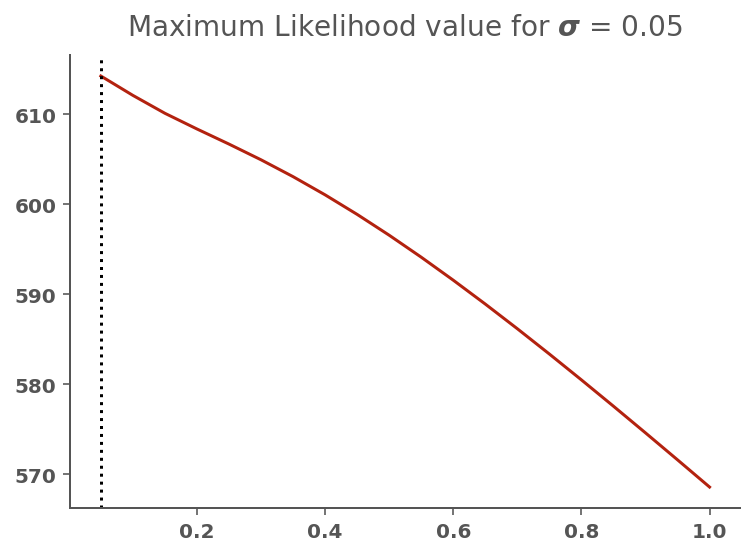

In [16]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for county_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()
# print(max_likelihood_index)

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

In [17]:
sigma

0.05

### Compile Final Results

Given that we've selected the optimal $\sigma$, let's grab the precalculated posterior corresponding to that value of $\sigma$ for each state. Let's also calculate the 90% and 50% highest density intervals (this takes a little while) and also the most likely value.

In [18]:
final_results = None
hdi_error_list = []

for county_name, result in results.items():
    print(county_name)
    try:
        posteriors = result['posteriors'][max_likelihood_index]
        hdis_90 = highest_density_interval(posteriors, p=.9)
        hdis_50 = highest_density_interval(posteriors, p=.5)
        most_likely = posteriors.idxmax().rename('ML')
        result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
        if final_results is None:
            final_results = result
        else:
            final_results = pd.concat([final_results, result])
        clear_output(wait=True)
    except:
        print(f'hdi failed for {county_name}')
        hdi_error_list.append(county_name)
        pass

print(f'HDI error list: {hdi_error_list}')
print('Done.')

Yamhill


hdi failed for Yamhill
HDI error list: ['Benton', 'Clatsop', 'Columbia', 'Coos', 'Crook', 'Curry', 'Deschutes', 'Douglas', 'Gilliam', 'Grant', 'Harney', 'Hood River', 'Jackson', 'Josephine', 'Klamath', 'Lake', 'Lincoln', 'Malheur', 'Morrow', 'Polk', 'Tillamook', 'Union', 'Wallowa', 'Wasco', 'Yamhill']
Done.


### Plot All Counties meeting criteria

In [19]:
def plot_rt(result, ax, county_name):
    
    ax.set_title(f"{county_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

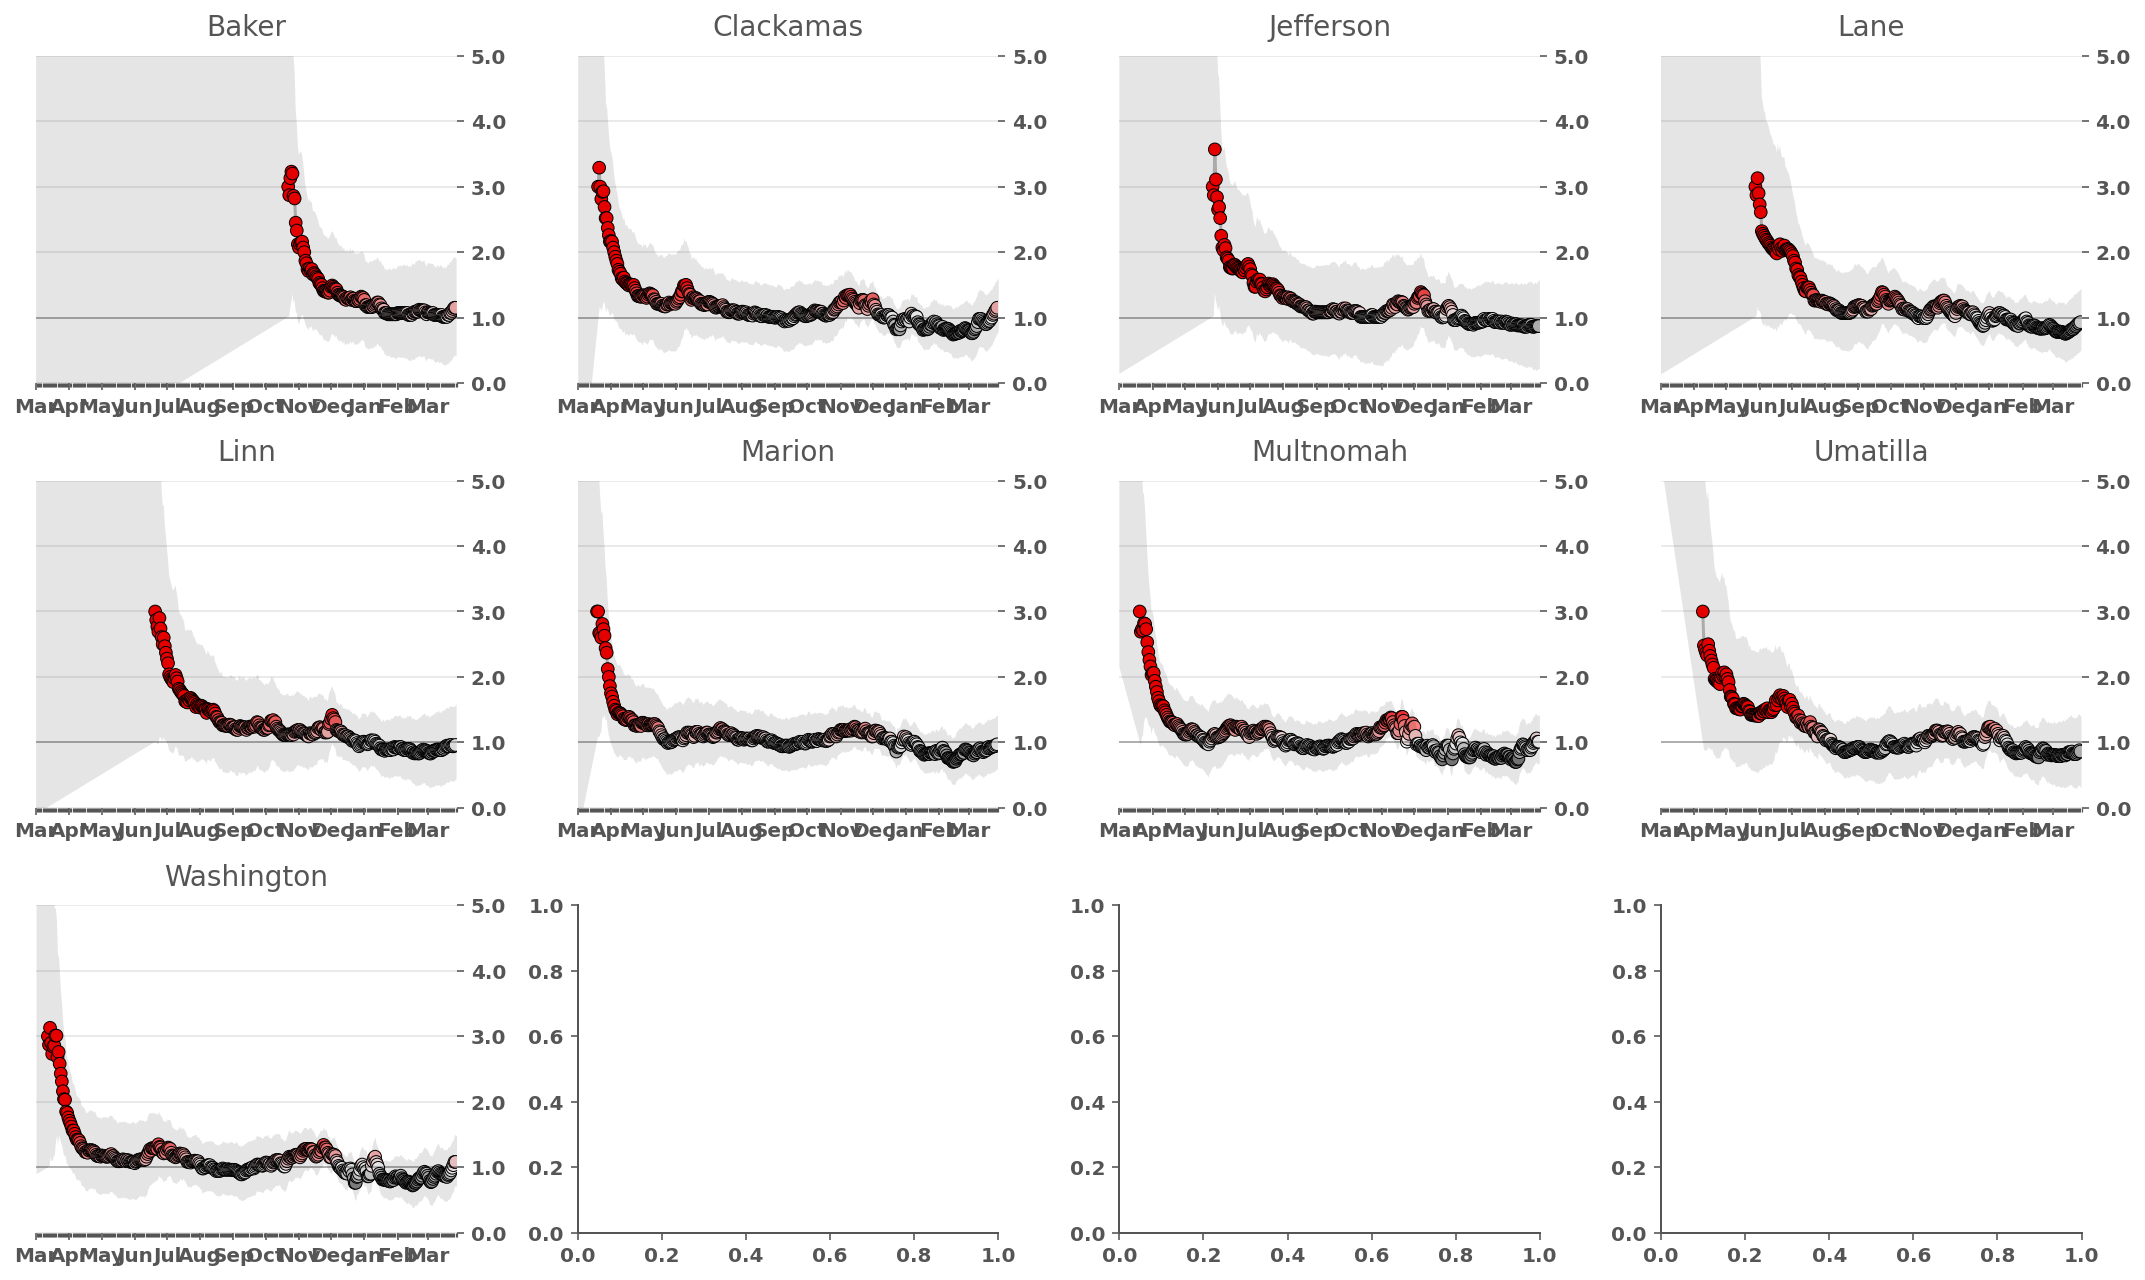

In [20]:
ncols = 4
nrows = int(np.ceil(len(final_results.groupby('county')) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (county_name, result) in enumerate(final_results.groupby('county')):
    plot_rt(result, axes.flat[i], county_name)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [21]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv(f'data/rt_usa_{selected_state}_counties.csv')

### Standings

In [22]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [23]:
final_results

ML  Low_90  High_90  Low_50  High_50
county     date                                              
Baker      2020-10-22  3.00    1.01     6.99    2.04     4.45
           2020-10-23  2.87    1.02     6.29    1.95     4.11
           2020-10-24  3.13    1.16     6.41    2.24     4.43
           2020-10-25  3.23    1.24     6.08    2.33     4.37
           2020-10-26  3.20    1.36     5.71    2.42     4.26
...                     ...     ...      ...     ...      ...
Washington 2021-03-23  0.95    0.57     1.37    0.81     1.14
           2021-03-24  0.99    0.61     1.41    0.86     1.19
           2021-03-25  1.03    0.63     1.42    0.90     1.23
           2021-03-26  1.08    0.71     1.50    0.96     1.29
           2021-03-27  1.08    0.71     1.49    0.94     1.26

[2901 rows x 5 columns]

/opt/hostedtoolcache/Python/3.6.13/x64/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


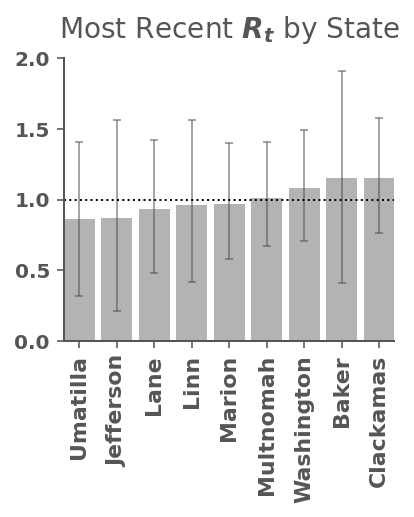

In [24]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

/opt/hostedtoolcache/Python/3.6.13/x64/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


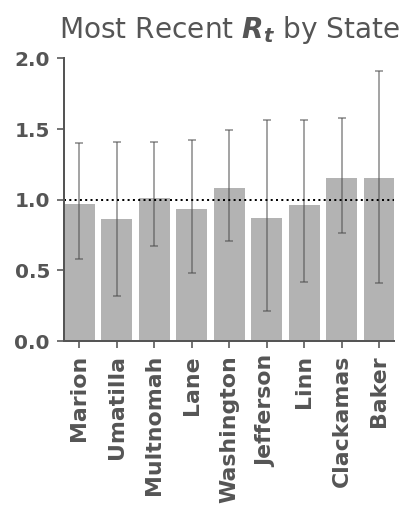

In [25]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

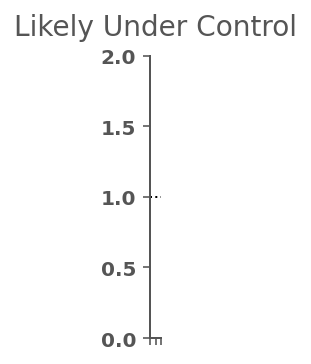

In [26]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

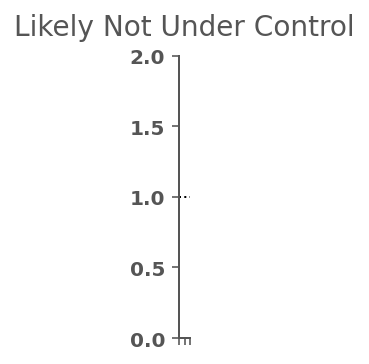

In [27]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');